<h1>Image Correction Tests</h1>
<p>- Here we will use the master flats and biases to calibrate images.</p>
<p>we can use the 2d cutout methods later that pull wcs info potentially. </p>

In [5]:

'''
load images the same way as did last time
'''

import os
import collections 
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#user specific path...
directory = '/Users/spencerfreeman/Desktop/stepUp/freeman2024-09-03'
transit_name = 'WASP-135b'
#this linked list stores float arrays of each image, these can be manipulated.


light_frame_indicator = "lrp"
flat_frame_indicator = "frp.fit"
bias_frame_indicator = "bias.fit"

'''
if it turns out we need more information from the fits images, then the file objects must be adjusted in these methods.
'''
#helper method
def print_guidance(name_indicator, directory):
    print("+------------------------------------------------------------------------------------------------------------+")
    print("loading images from {0} including the string {1}...".format(directory, name_indicator))
    print("+------------------------------------------------------------------------------------------------------------+")

#running method
#load light frames loads actual fits files. to accsess the pixel array we must use [0].data on each object in the lights array. 
def load_light_frames(directory, light_frame_indicator):
    light_frame_linkedlist = collections.deque()
    print_guidance(light_frame_indicator, directory)
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f) and light_frame_indicator in filename:
            file = fits.open(f)
            light_frame_linkedlist.append(file)
    return light_frame_linkedlist

def load_bias_frames(directory, bias_frame_indicator):
    print_guidance(bias_frame_indicator, directory)
    bias_frame_linkedlist = collections.deque()
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f) and bias_frame_indicator in filename:
            file = fits.open(f)
            bias_frame_linkedlist.append(file)
    return bias_frame_linkedlist

def load_flat_frames(directory, flat_frame_indicator):
    print_guidance(flat_frame_indicator, directory)
    flat_frame_linkedlist = collections.deque()
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f) and flat_frame_indicator in filename:
            file = fits.open(f)
            flat_frame_linkedlist.append(file)
    return flat_frame_linkedlist

#linked list storing lights wil now be stored in l
lights = load_light_frames(directory, light_frame_indicator)
flats = load_flat_frames(directory, flat_frame_indicator)
biases = load_bias_frames(directory, bias_frame_indicator)

print('total lights loaded: {0}'.format(len(lights)))
print('total flats loaded: {0}'.format(len(flats)))
print('total biases loaded: {0}'.format(len(biases)))
#plt.imshow(fits.open(os.path.join(directory, "mflat.fit"))[0].data)
# plt.imshow(lights[0])
# plt.imshow(flats[0])
 

+------------------------------------------------------------------------------------------------------------+
loading images from /Users/spencerfreeman/Desktop/stepUp/freeman2024-09-03 including the string lrp...
+------------------------------------------------------------------------------------------------------------+
+------------------------------------------------------------------------------------------------------------+
loading images from /Users/spencerfreeman/Desktop/stepUp/freeman2024-09-03 including the string frp.fit...
+------------------------------------------------------------------------------------------------------------+
+------------------------------------------------------------------------------------------------------------+
loading images from /Users/spencerfreeman/Desktop/stepUp/freeman2024-09-03 including the string bias.fit...
+------------------------------------------------------------------------------------------------------------+
total lights loa

In [6]:
print(flats[0][0].data)

[[27164 27064 26874 ... 27050 27127 26818]
 [27257 27276 26906 ... 26927 26761 26507]
 [26753 27164 26839 ... 27115 26784 26597]
 ...
 [27802 27711 27525 ... 27896 27569 27791]
 [27530 27359 26730 ... 27235 27068 26773]
 [ 2553  2492  2550 ...  2445  2397  2267]]


In [7]:
'''
return our array dimensions for resizing purposes...
'''
def return_dimensions(pixel_2d_array):
    return ([len(pixel_2d_array), len(pixel_2d_array[0])])

return_dimensions(flats[0][0].data)

[4096, 4096]

[[0.85232328 0.84793973 0.84615385 ... 0.85193363 0.85112186 0.84206254]
 [0.85034257 0.85397928 0.84394584 ... 0.84621879 0.84923856 0.83826347]
 [0.85024515 0.8506348  0.84459525 ... 0.84836185 0.84021171 0.84027665]
 ...
 [0.87031204 0.86787674 0.8640452  ... 0.87875442 0.86547391 0.86479203]
 [0.85872001 0.85547294 0.838231   ... 0.85638212 0.85209598 0.85193363]
 [0.05156346 0.05221288 0.05250511 ... 0.04903075 0.04812157 0.04454979]]


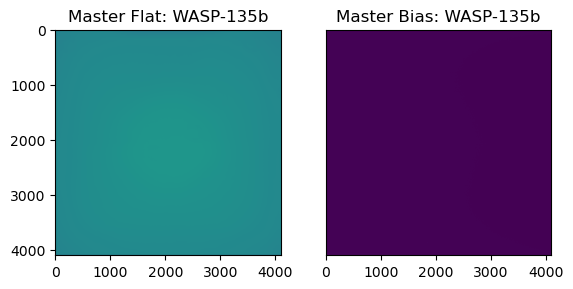

In [8]:
'''
Here we will take the average of across the flats and bias images to obtain master flats and biases.
If we only have one flat and/or bias loaded, we can skip this step.
TODO: write the master flat and bias to the subdirectory. 
TODO: linked lists need to contain fits files for write out, we will try to adjust the data of specific fits object attributes and preserve the file type to not lose fits info
TODO: understand the descrepancy between sum mehtods in the flat frame method, is this also present in the bias frame method?
'''
import matplotlib.ticker as ticker
fig, (ax1, ax2) = plt.subplots(1,2)

def make_sub_dir(directory):
    new_directory = directory + "/processed_by_pipeline"
    if(os.path.exists(new_directory) == False):
        os.makedirs(new_directory)
    return new_directory

#make new dir outside of these funcitons
new_directory = make_sub_dir(directory)

def median_flats(flats, biases, total_flats, total_biases, directory, new_directory):
    # dimensions = return_dimensions(flats[0][0].data)
    # master_flat_pixel_array = [[0]*dimensions[1]]*dimensions[0]
    make_sub_dir(directory)
    
    if(len(flats) == 0):
        print("***image load failure, please check path and retry.***")
    #case in which only one flat is present
    elif(len(flats) == 1):
        
        bright_value = get_bright_value(median_flat)
        median_bias = np.median(biases)
        master_flat_pixel_array = (median_flat - median_bias)/bright_value
        ax1.imshow(master_flat_pixel_array)
        ax1.set_title("Master Flat: {0}".format(transit_name))
        return master_flat_pixel_array
    
    elif(len(flats)>1):
        '''
        *to build a master flat image we will take median of the flats and then subtract the average of the biases.*
        we should probably subtract and then take the median...
        '''
        median_flat = np.median(flats, axis=0)
        bright_value = get_bright_value(median_flat)
        median_bias = np.median(biases)
        master_flat_pixel_array = (median_flat - median_bias)/bright_value
        ax1.imshow(master_flat_pixel_array)
        write_to_directory(master_flat_pixel_array, 'mflat.fits', new_directory)
        ax1.set_title("Master Flat: {0}".format(transit_name))
        return master_flat_pixel_array
    
def median_biases(biases, total_biases, directory, new_directory):
    make_sub_dir(directory)
    if(len(biases) == 0):
        print("***image load failure, please check path and retry.***")
    elif(len(biases) == 1):
        master_bias_pixel_array = biases[0][0].data
        plt.imshow(master_bias)
        ax2.set_title("Master Bias: {0}".format(transit_name))
        ax2.yaxis.set_major_locator(ticker.NullLocator())
        write_to_directory(master_bias_pixel_array, 'mbias.fits', new_directory)
        return master_bias_pixel_array
    elif(len(biases) > 1):
        master_bias_pixel_array = np.median(biases, axis=0)
        ax2.imshow(master_bias_pixel_array)
        ax2.set_title("Master Bias: {0}".format(transit_name))
        #hide the tick marks on the master bias plot
        ax2.yaxis.set_major_locator(ticker.NullLocator())
        write_to_directory(master_bias_pixel_array, 'mbias.fits', new_directory)
        return master_bias_pixel_array

def get_bright_value(master_flat_pixel_array_pre_sub):
    values = []
    dimension = int(return_dimensions(master_flat_pixel_array_pre_sub)[0])
    dist = 100
    for i in range(dimension//2-dist, dimension//2+dist):
        for j in range(dimension//2-dist, dimension//2+dist):
            values.append(master_flat_pixel_array_pre_sub[i][j])
    median_bright = np.median(values)
    return median_bright
    
def fits_to_array(fits_list):
    pixel_arrays = []
    for file in fits_list:
        pixel_arrays.append(file[0].data)
    return pixel_arrays

def write_to_directory(master_pixel_array, filename, new_directory):
    path = new_directory
    hdu = fits.PrimaryHDU(master_pixel_array)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(os.path.join(new_directory, filename), overwrite=True)

#lets have a copy of all 
flat_pixel_array_list = fits_to_array(flats)
bias_pixel_array_list = fits_to_array(biases)
lights_pixel_array_list = fits_to_array(lights)

master_flat_pixel_array = median_flats(flat_pixel_array_list, bias_pixel_array_list, len(flats), len(biases), directory, new_directory)
master_bias_pixel_array = median_biases(bias_pixel_array_list, len(biases), directory, new_directory)
print(master_flat_pixel_array)

----
[[1998 1990 1973 ... 2015 2007 1996]
 [2078 2043 1999 ... 2009 1995 2048]
 [2062 2078 2033 ... 2014 2038 1974]
 ...
 [2105 2096 2065 ... 1984 1998 2064]
 [2031 2099 2076 ... 2018 2034 2085]
 [1148 1157 1160 ... 1067 1073 1051]]
----
[[0.85232328 0.84793973 0.84615385 ... 0.85193363 0.85112186 0.84206254]
 [0.85034257 0.85397928 0.84394584 ... 0.84621879 0.84923856 0.83826347]
 [0.85024515 0.8506348  0.84459525 ... 0.84836185 0.84021171 0.84027665]
 ...
 [0.87031204 0.86787674 0.8640452  ... 0.87875442 0.86547391 0.86479203]
 [0.85872001 0.85547294 0.838231   ... 0.85638212 0.85209598 0.85193363]
 [0.05156346 0.05221288 0.05250511 ... 0.04903075 0.04812157 0.04454979]]
----
[[ 2344.18095927  2346.86490005  2331.72727273 ...  2365.20772192
   2358.06420723  2370.37026183]
 [ 2443.72101726  2392.32969582  2368.63541226 ...  2374.0905184
   2349.16322551  2443.145956  ]
 [ 2425.18289097  2442.88147498  2407.07012418 ...  2373.98698664
   2425.5791467   2349.2262926 ]
 ...
 [ 2418.6727

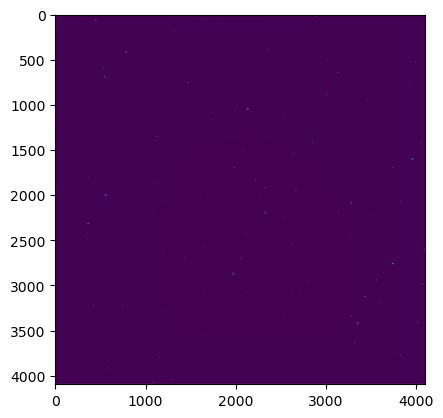

In [18]:
f = os.path.join(new_directory, 'mbias.fits')
file = fits.open(f)
light_trial = lights_pixel_array_list[0]
print("----")
print(light_trial)
print("----")
print(master_flat_pixel_array)
print("----")
trial = (light_trial - master_bias_pixel_array)/master_flat_pixel_array
print(light_trial/master_flat_pixel_array)
write_to_directory(trial, 'lrp.fits', new_directory)
plt.imshow(light_trial/master_flat_pixel_array)

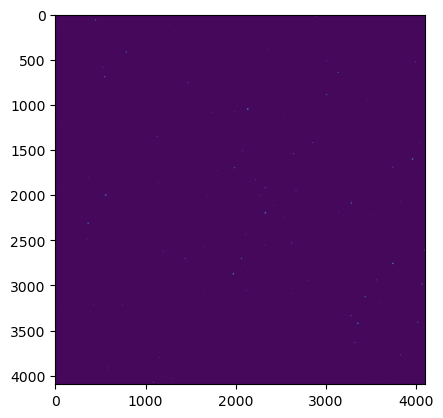

In [28]:
'''
calibration of lights involves subraction of the master bias from light frames followed by division of light pixels by the master flat
'''
plt.imshow(lights[0][0].data)

def calibrate_lights(lights, lights_pixel_array_list, master_bias_pixel_array, master_flat_pixel_array, new_directory):
    #check if path already exists for some reason
    #recall, lights is a deque of fits files
    #we seek to calibrate each one and write a fits file with an identical header to the processed directory, with the naming convention *_out.fits
    #for i in range(0, length(lights)):
    for i in range(0, len(lights)):
        header_copy = lights[i][0].header
        data_processed = (lights[i][0].data - master_bias_pixel_array)/master_flat_pixel_array
        path = new_directory
        hdu = fits.PrimaryHDU(data_processed, header_copy)
        hdulist = fits.HDUList([hdu])
        filename = transit_name + "_lrp_out{0}.fits".format(i)
        hdulist.writeto(os.path.join(new_directory, filename), overwrite=True)

calibrate_lights(lights, lights_pixel_array_list, master_bias_pixel_array, master_flat_pixel_array, new_directory)
    